<a href="https://colab.research.google.com/github/stojatesanovic/Employee_Salaries_Analysis/blob/main/Employee_Salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data, installing Spark and necessary libraries:

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=9b36f139757f101b3dc55512dcb652c67d769f182839588659456d5dcb2c89e1
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
!pip install kaggle

In [3]:
!pip install pyspark
!pip install kaggle
!git add .


fatal: not a git repository (or any of the parent directories): .git


In [4]:
!kaggle datasets download -d pavanelisetty/salarypredictions

Dataset URL: https://www.kaggle.com/datasets/pavanelisetty/salarypredictions
License(s): unknown
 77% 18.0M/23.3M [00:00<00:00, 34.9MB/s]
100% 23.3M/23.3M [00:00<00:00, 48.2MB/s]


In [5]:
!unzip salarypredictions.zip

Archive:  salarypredictions.zip
  inflating: test_dataset.csv        
  inflating: train_dataset.csv       
  inflating: train_salaries.csv      


In [6]:
import os
for dirname, _, filenames in os.walk('content/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [9]:
conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="PySpark, SQL and Machine learning for salary prediction", conf=conf)
sc

<SparkContext master=local[*] appName=PySpark, SQL and Machine learning for salary prediction>

In [10]:
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")

In [11]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [12]:
df_path = 'train_dataset.csv'
df1_path = 'train_salaries.csv'

In [13]:
df1 = spark.read.csv(df_path, header=True).cache()

In [14]:
df2 = spark.read.csv(df1_path, header=True).cache()

In [15]:
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [16]:
df2.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



In [17]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [18]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



After displaying the schema, we can observe that data such as salary, yearsExperience and milesFromMetropolis should be converted to integer type

In [19]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [20]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [21]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



Before we start the analysis, we will join the two dataframes on the jobId column. If we do this without any modifications, we will have two jobId columns, which could lead to confusion. To avoid this, we will rename the jobId column in the second dataframe. This way, we can drop it after the join, preventing any ambiguity with the jobId column in the first dataframe.

In [22]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

In [23]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [24]:
df = df.drop('job_id')

In [25]:
df.show(5)

+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|    CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24| JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+

# Checking for duplicates



In [26]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



There are no duplicate rows

# Checking for missing values

In [27]:
df.show(10)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24|        JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_

In [28]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))

Number of missing values for jobType: 0
Number of missing values for degree: 236854
Number of missing values for major: 532355
Number of missing values for industry: 0


These values are not missing but rather indicate that the worker does not have a degree or major. We will keep these values instead of removing them

# Dataset analysis

In [29]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885708| 28.877732628720178|38.71793638113286|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



# 1. Which is the highest paid job?

In [30]:
df.createOrReplaceTempView("data")

In [31]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



The highest paid jobs are CFO (Chief financial officer) and CTO (Chief technology officer ) in the OIL industry, with a salary of 301k$.

# 2. Which are the TOP 20 jobs in terms of highest salary?

In [32]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO| FINANCE|   1|
|   294|    CEO|     OIL|   4|
|   293|    CEO| FINANCE|   2|
|   293|    CEO|     OIL|   5|
|   292|    CEO| FINANCE|   3|
|   292|    CTO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CEO| FINANCE|   5|
|   289|    CFO|     OIL|   6|
|   289|    CTO|     WEB|   2|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



# 3. Which is the least paid job?

In [33]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|        JUNIOR|      OIL|   1|
|     0|       MANAGER|  FINANCE|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|           CTO|     AUTO|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



In [34]:
df = df.where("salary != 0")

In [35]:
df.createOrReplaceTempView("data")

In [36]:
df_q3 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



# 4. Which are the TOP 3 industries in terms of highest salary?

In [37]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(3)

+--------+------------------+
|industry|    average_salary|
+--------+------------------+
|     OIL|130.95386285634237|
| FINANCE|  130.747658645164|
|     WEB| 121.6453615446388|
+--------+------------------+
only showing top 3 rows



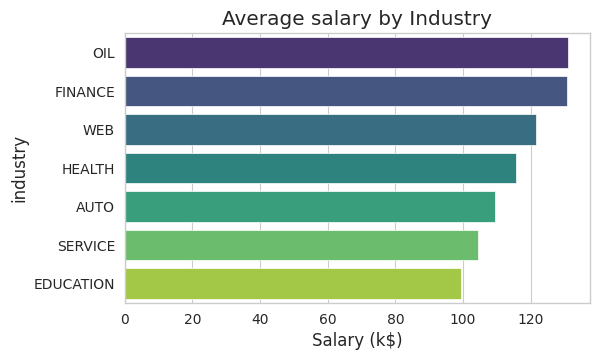

In [38]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

# 5. Do workers with more years of experience get paid more?

In [39]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''')
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO|     OIL|             22|
|   287|    CEO| FINANCE|             19|
|   286|    CTO| FINANCE|             24|
|   286|    CEO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In order to improve the readability of the results, we will plot salary VS jobtype. Before doing so, we should check the different jobtypes in the dataframe:

In [40]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [41]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

In [42]:
df_p = df_q5.toPandas()

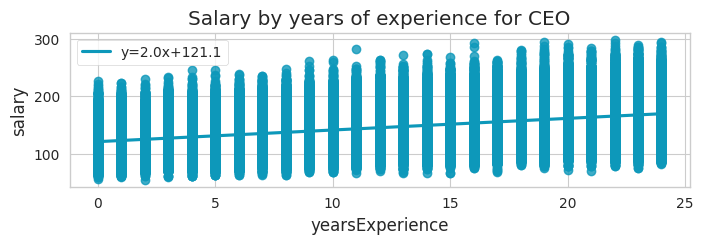

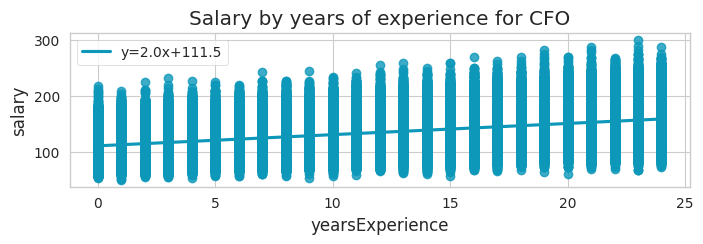

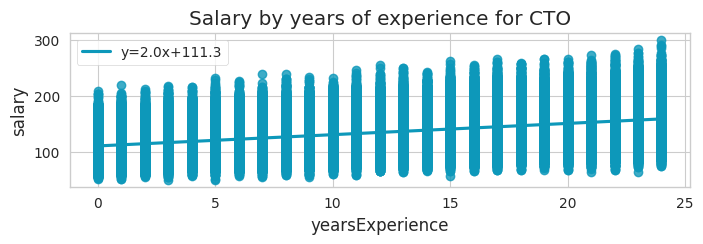

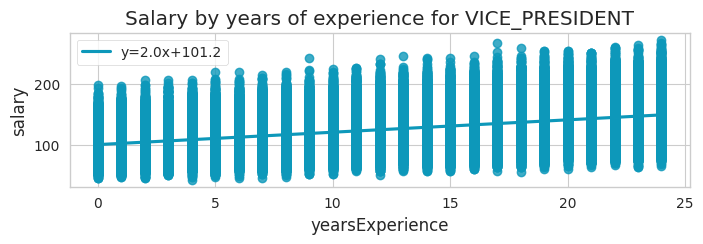

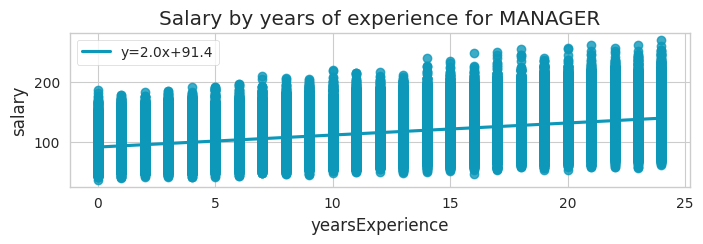

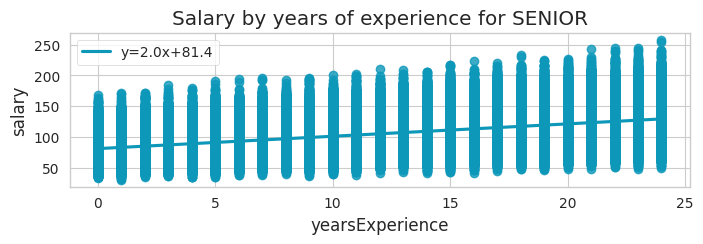

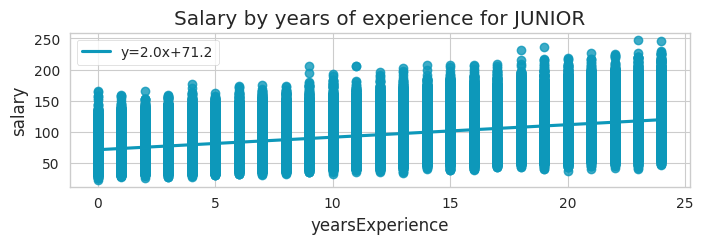

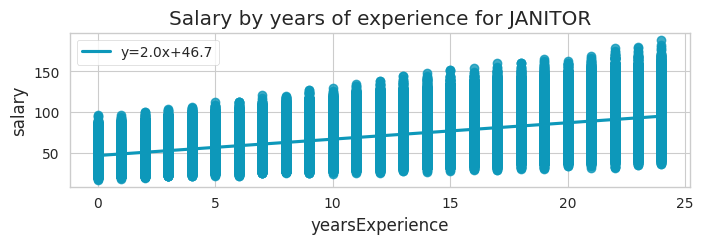

In [43]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Load data
salaries_path = "train_salaries.csv"
jobs_path = "train_dataset.csv"

salaries_df = spark.read.csv(salaries_path, header=True, inferSchema=True)
jobs_df = spark.read.csv(jobs_path, header=True, inferSchema=True)

# Join data
data_df = salaries_df.join(jobs_df, on="jobId")

# Show data
data_df.show(5)


+----------------+------+---------+-------+-----------+---------+---------+---------------+-------------------+
|           jobId|salary|companyId|jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|
+----------------+------+---------+-------+-----------+---------+---------+---------------+-------------------+
|JOB1362684407687|   130|   COMP37|    CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   101|   COMP19|    CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|
|JOB1362684407690|   142|   COMP38|MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407693|   178|   COMP15|    CFO|       NONE|     NONE|   HEALTH|             23|                 24|
|JOB1362684407694|    73|   COMP24| JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|
+----------------+------+---------+-------+-----------+---------+---------+---------------+-------------

In [45]:
# # Konvertuj odgovarajuće kolone na numeričke tipove
# data_df = data_df.withColumn("salary", col("salary").cast("double"))
# data_df = data_df.withColumn("yearsExperience", col("yearsExperience").cast("double"))
# data_df = data_df.withColumn("milesFromMetropolis", col("milesFromMetropolis").cast("double"))

# # Prikaži šemu podataka da potvrdimo tipove
# data_df.printSchema()


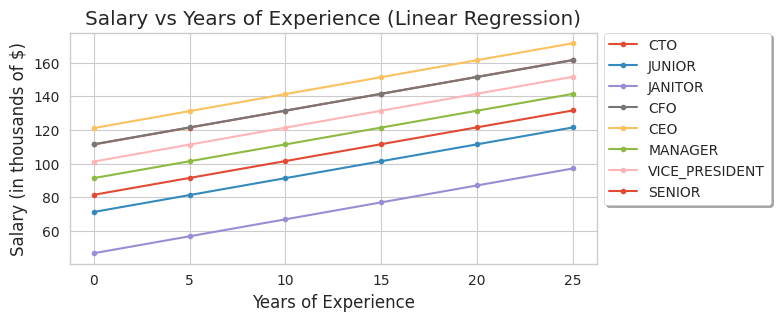

In [46]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# List of unique job types
job_type_list = [row["jobType"] for row in data_df.select("jobType").distinct().collect()]

# Lists to store coefficients
slope_list = []
intercept_list = []

# Train a model for each job type
for job_type in job_type_list:
    # Filter data for the current job type
    job_type_df = data_df.filter(col("jobType") == job_type)

    # Prepare data for the model
    assembler = VectorAssembler(inputCols=["yearsExperience"], outputCol="features")
    job_type_df = assembler.transform(job_type_df)

    # Create and train the linear regression model
    lr = LinearRegression(featuresCol='features', labelCol='salary')
    lr_model = lr.fit(job_type_df)

    # Append coefficients to lists
    slope_list.append(lr_model.coefficients[0])
    intercept_list.append(lr_model.intercept)

# Display the plot
import matplotlib.pyplot as plt
import numpy as np

X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8, 3))

# Plot lines for each job type
for i in range(len(job_type_list)):
    plt.plot(X, slope_list[i]*X + intercept_list[i], label=job_type_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)

# Set axis labels and title
plt.ylabel('Salary (in thousands of $)')
plt.xlabel('Years of Experience')
plt.title('Salary vs Years of Experience (Linear Regression)')
plt.show()


# 6. Do workers with higher degrees have better paid jobs?

In [47]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



Drop NONE values

In [48]:
df_q6 = df_q6.replace('NONE',None)

In [49]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NULL|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NULL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NULL|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [50]:
df_q6 = df_q6.na.drop()

In [51]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [52]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [53]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','MASTERS','DOCTORAL']

In [54]:
df_p = df_q6.toPandas()

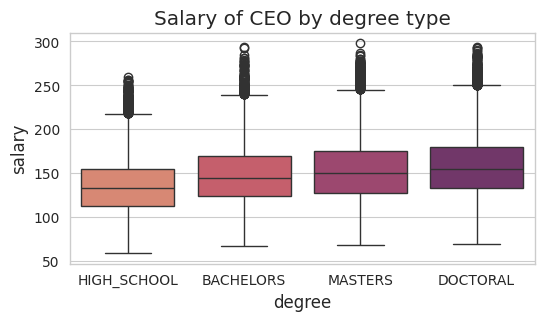

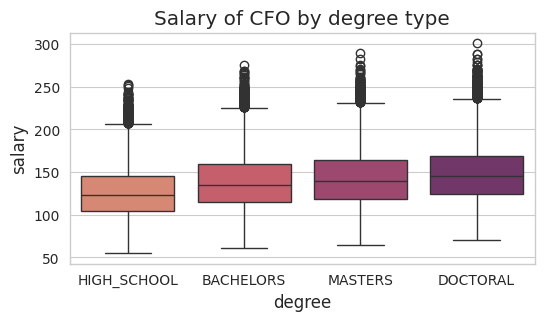

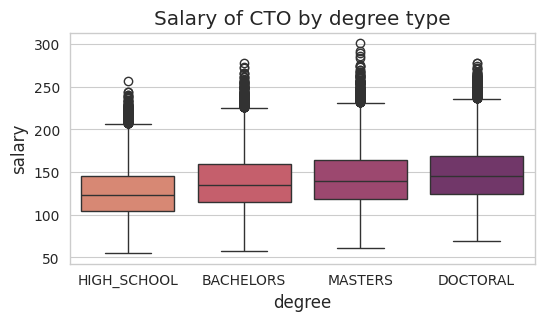

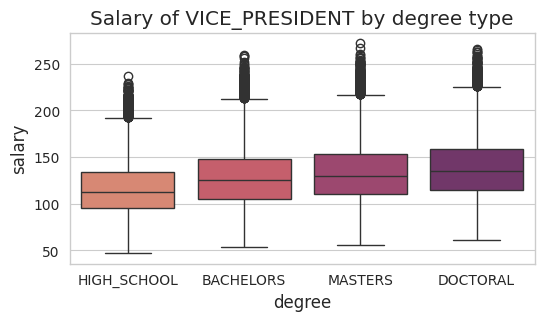

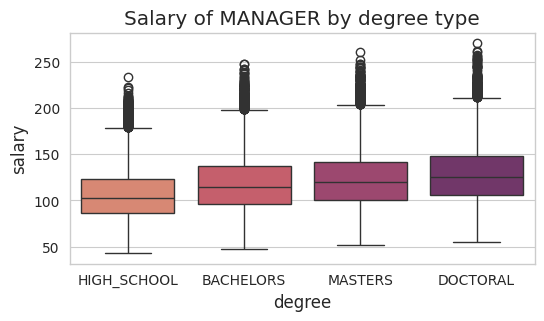

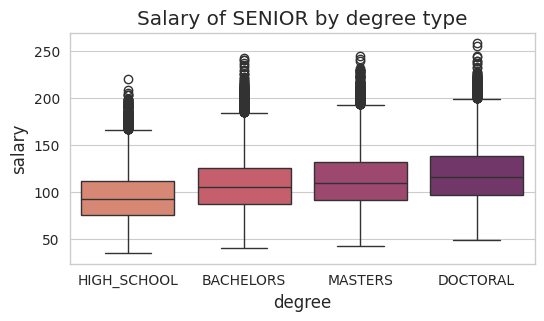

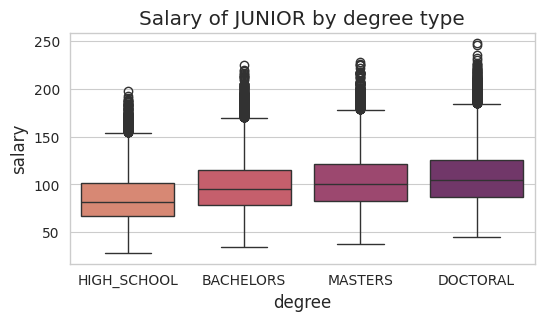

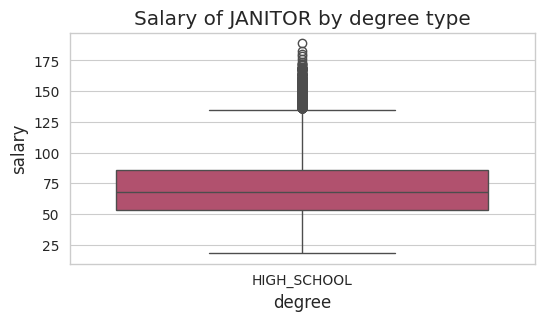

In [55]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

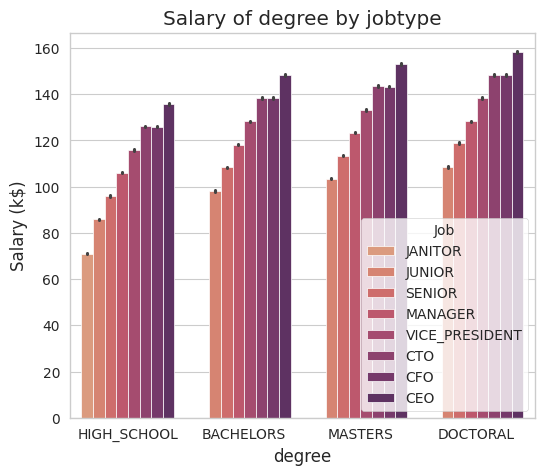

In [56]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

All job types in this dataset, higher educated workers get paid more.
In case of JANITOR as a jobtype, there are only people with a High school education.

# 7. Does the major affects the salary?

In [57]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



Since it is assumed that high school does not have a specific major, we will need to drop values that are NONE."

In [58]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [59]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [60]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In [61]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [62]:
df_p = df_q7.toPandas()

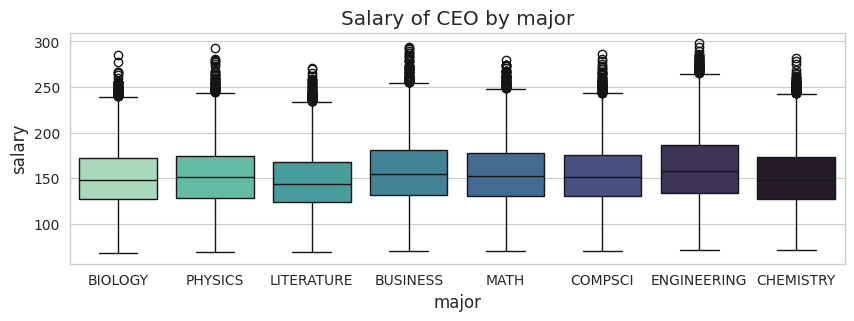

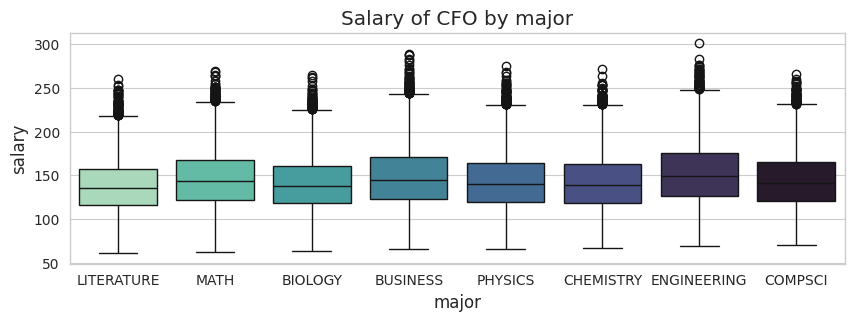

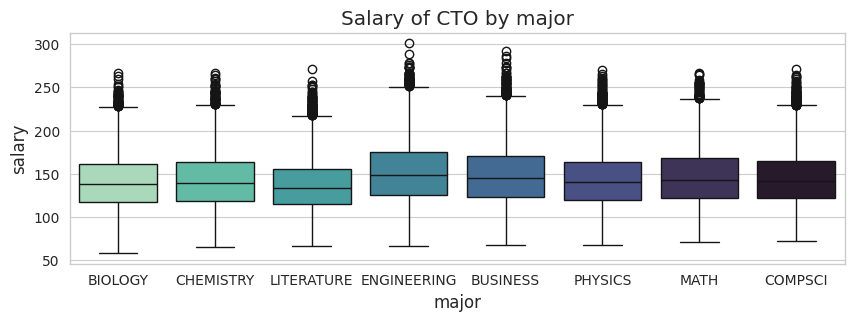

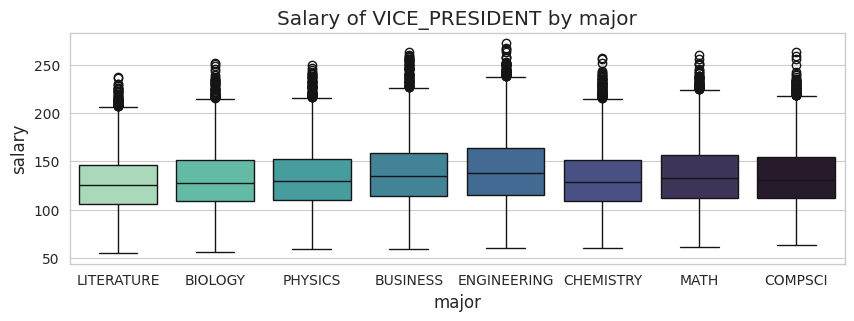

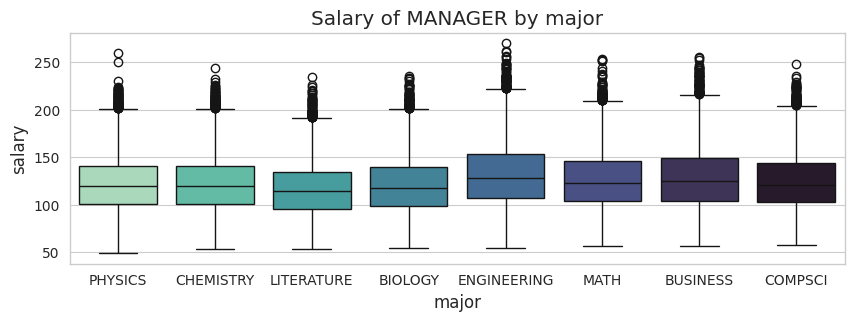

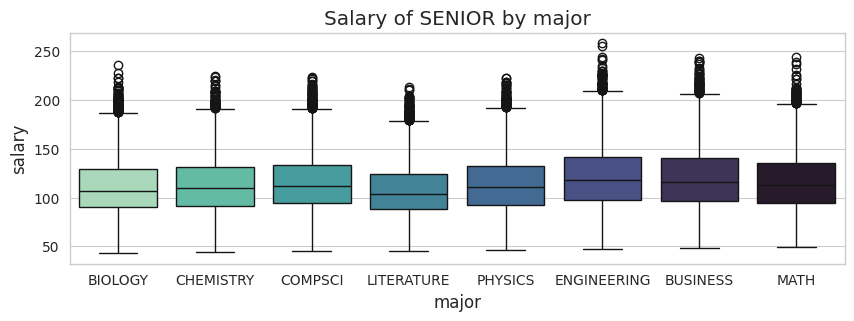

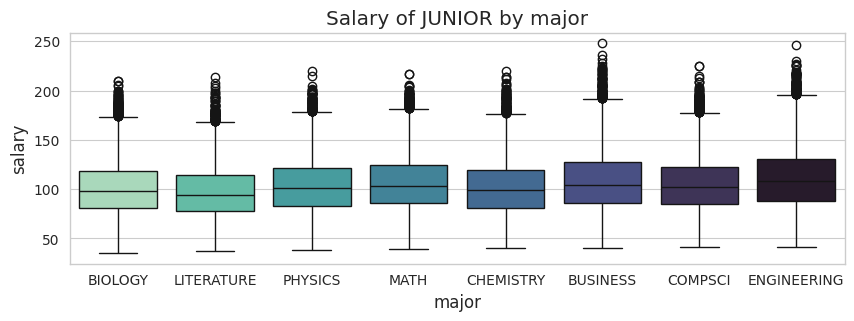

In [63]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

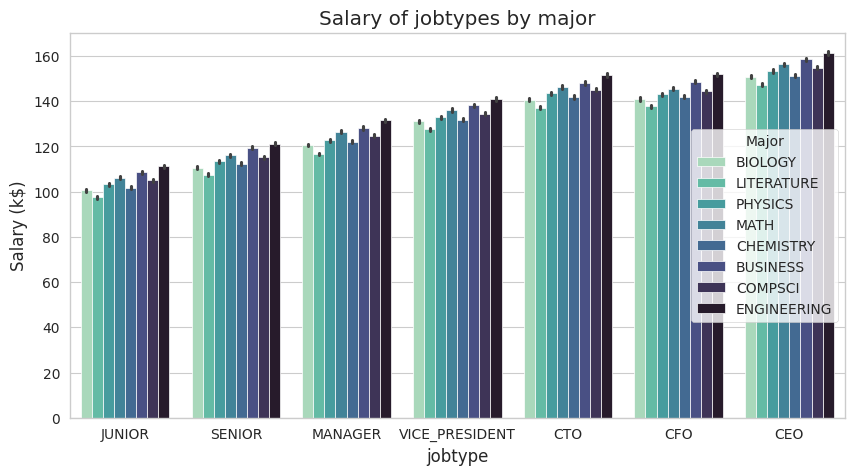

In [64]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

# ML Modeling
Prepreocess the data for ML training.

In [65]:
df.show(1)

+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|           jobId|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



In [66]:
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)  # False

False

In [67]:
df_encoded = df_encoded.drop('jobId')

In [68]:
cols = df_encoded.columns

In [69]:
salary_df = df_encoded.select('salary').toPandas()

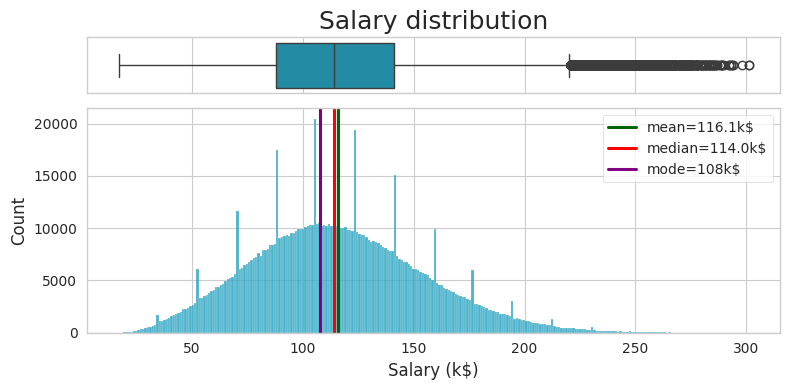

In [70]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Salary distribution',fontsize=18)
sns.boxplot(x='salary', data=salary_df, ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary', data=salary_df, ax=ax[1], color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()

Salary feature has a right skewed long tail distribution, with some salaries which appears lots of times in the dataset (the "spikes" in this histograms).

**Label Encoding**

Label encoding is a naive method to encode the categorical features. Label encoding should be used when there is a order among the categories

In [71]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [72]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

# One hot Encoding

To apply one-hot encoding on the dataset, we first need to use a string indexer, similar to the label encoder, and then perform the actual one-hot encoding. After that, these steps will be stored in a "stages" variable and passed to a Pipeline object for processing.

In [73]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [74]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [75]:
df_encoded.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



We observe a "features" column that contains all the encoded categorical features using one-hot encoding, along with the numerical features. This "features" column, along with the target column "salary," will be provided to the ML algorithm during training.

Train test

In [76]:
train, test = df_encoded.randomSplit([0.995, 0.005], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 994972 training examples and 5023 test examples.


# Gradient Boosting Trees

In [77]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [78]:
gbt_model = gbt.fit(train)

In [79]:
predictions = gbt_model.transform(test)

In [80]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

18.998999749304076

# Prediction results

In [81]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7541557304890221

In [82]:
rf_results = predictions.toPandas()

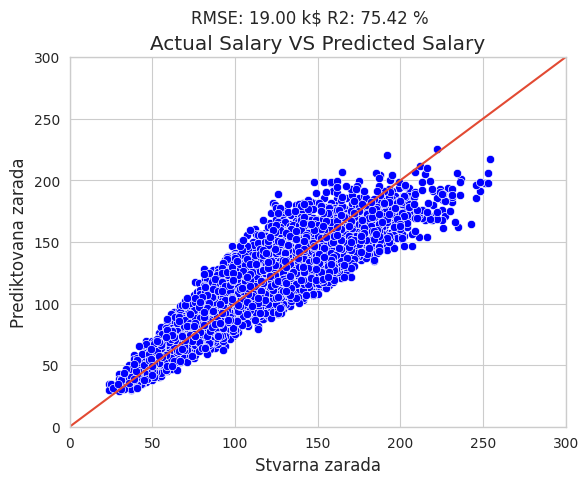

In [83]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Stvarna zarada')
plt.ylabel('Prediktovana zarada')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [84]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.00 k$ 
R2: 75.42 %


The algorithm shows better accuracy in predicting salaries below 130k, while it begins to underestimate those above 175k$. This might be caused by the right-skewed nature of the salary distribution. In general, the results are satisfactory in terms of both RMSE and R². Additional improvements could be made through hyperparameter tuning and more advanced feature engineering.

In [85]:
spark.stop()